# Expression Recognition - Short overview
1. We are given an image containing a face.

2. We classify the face in image to be happy or sad or angry etc..

3. Our images are 50 X 50 in size.

4. We use 'compact embedding' to extract important Features out of the image

5. We then use this as a 'Feature Vector' for data.

6. We train the model using SVM.

7. We then print the accuracy score for test data.


# Sample Image

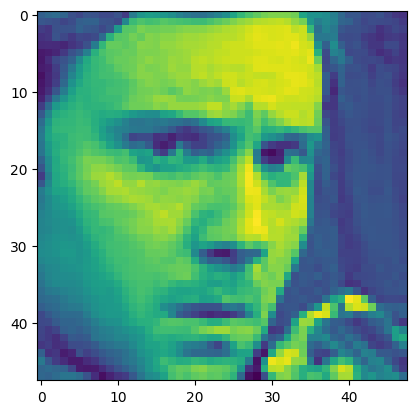

In [24]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
from scipy.signal import convolve2d
from PIL.ImageFilter import GaussianBlur
import os


im = Image.open("sample/0.jpg").convert("L")
plt.figure()
plt.imshow(numpy.array(im))

# Embeddings

We try two different embeddings:
1. Edge detection algorithm.
2. Uniform Local Binary Pattern Histogram

## Edge detection: Robert Cross Edge detector
1. The Roberts Cross operator performs a simple, quick to compute, 2-D spatial gradient measurement on an image. It thus highlights regions of high spatial frequency which often correspond to edges.

2. In theory, the operator consists of a pair of 2×2 convolution kernels as shown in Figure 1. One kernel is simply the other rotated by 90°. 

![alt text](sample/robert_cross.jpg)

3. We apply this convolution using scipy's convolve2d to each pixel

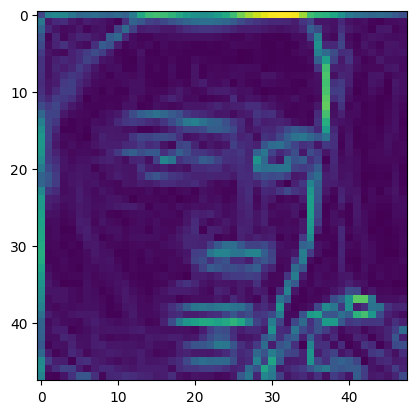

In [25]:
def _get_image_as_array(path: str):
    im = Image.open(path)
    im = im.convert(mode="L")
    
    arr = numpy.asarray(im)

    return arr

def _robert_edge_detector(path: str, blur: float, passfilter: int):
    #gx = numpy.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    #gy = numpy.array([[1,2,1],[0,0,0], [-1,-2,-1]])

    gx = numpy.array([[1,0],[0,-1]])
    gy = numpy.array([[0,1], [-1,0]])

    im = Image.open(path).convert("L")
    im = numpy.asarray(im)

    GX = convolve2d(im, gx, mode='same') 
    GY = convolve2d(im, gy, mode='same')

    if blur > 0:
        G = numpy.array([[0.1,0.1],[0.1,0.1]])
        im = convolve2d(im, blur*G, mode='same')

        GX = convolve2d(im, gx, mode='same') * 1/numpy.sum(G)
        GY = convolve2d(im, gy, mode='same') * 1/numpy.sum(G)

    
    ret = numpy.absolute(GX) + numpy.absolute(GY)

    if passfilter > 0:
        th = passfilter
        th = numpy.average(ret)
        indxL = numpy.where(ret < th)
        indxH = numpy.where(ret >= th)

        ret[indxL] = 0
        ret[indxH] += 50 

    return ret

im = _robert_edge_detector('sample/0.jpg', -1, -1)
plt.figure()
plt.imshow(im)

# Uniform Local Binary Pattern Histogram

1. The operator labels the pixels of an image by thresholding the 3x3-neighbourhood of each pixel with the center value and considering the result as a binary number.

2. Then the histogram of the labels can be used as a texture descriptor.

3.  A Local Binary Pattern is called uniform if it contains at most two bitwise transitions from 0 to 1 or vice versa.

4. In total there are 93 such numbers in range [0, 256] given by get ubins() function.

5. We split the given image into 9 tiles of 16 x 16 size.

6. Each tile gets a histogram of its's own.

7. Finally the feature vector is of size 837.

8. We can see that we reduced the FV size from 2500 to 837.

Text(0.5, 1.0, 'Histogram obtained from ULBPH algorithm')

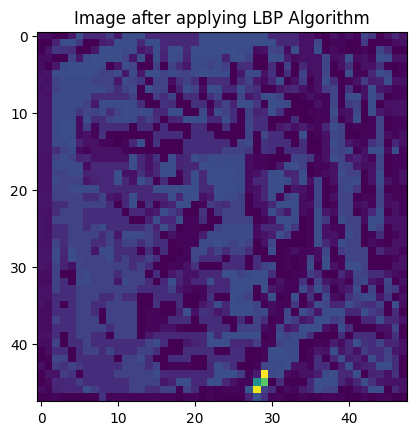

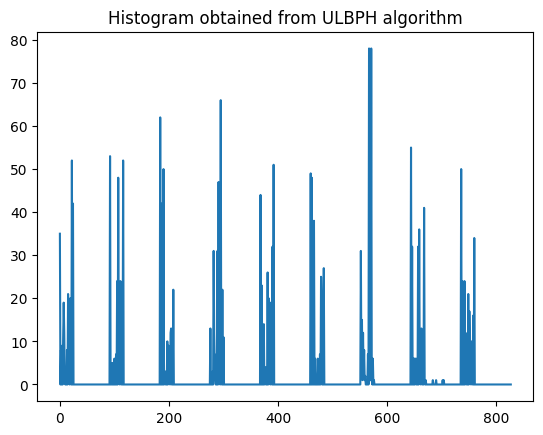

In [26]:
def _split_mat(arr: numpy.ndarray, blk_size: int = 16):
    l = numpy.split(arr, list(range(blk_size,arr.shape[0],blk_size)))
    split = []
    for x in l:
        tmp = numpy.split(x, list(range(blk_size,arr.shape[0],blk_size)), axis=1)
        for y in tmp:
            split.append(y)
    return split
# bin(4)
def get_ubins():
    bins = []
    for i in range(256):
        bin_form = bin(i)
        bin_form = bin_form[2:]
        trns = 0
        #while len(bin_form) <= 8:
         #  bin_form = '0' + bin_form
        curr = bin_form[0]
        prev = bin_form[0]
        for x in bin_form:
            prev = curr
            curr = x
            if curr != prev:
                trns +=1
        if trns <= 2:
            bins.append(i)
    return bins

bins = get_ubins()

def _lbph_algorithm(path: str, ubins: list):
    im = Image.open(path).convert("L")
    im = numpy.array(im)
    min_indx = 0
    max_indx = im.shape[0]
    im.setflags(write=True)

    for i in range(max_indx):
        for j in range(max_indx):

            lbp = ''

            if (i-1) > min_indx and (j-1) > min_indx:
                if im[i][j] >= im[i-1][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i-1) > min_indx and (j) < max_indx:
                if im[i][j] >= im[i-1][j]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i-1) > min_indx and (j+1) < max_indx:
                if im[i][j] >= im[i-1][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i) < max_indx and (j+1) < max_indx:
                if im[i][j] >= im[i][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j+1) < max_indx:
                if im[i][j] >= im[i+1][j+1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i+1) < max_indx and (j) < max_indx:
                if im[i][j] >= im[i+1][j]:
                    lbp += '0'
                else:
                    lbp += '1'
            
            if (i+1) < max_indx and (j-1) > min_indx:
                if im[i][j] >= im[i+1][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            if (i) < max_indx and (j-1) > min_indx:
                if im[i][j] >= im[i][j-1]:
                    lbp += '0'
                else:
                    lbp += '1'

            im[i][j] = int(lbp,2)
    
    tiles = []

    tiles = _split_mat(im)
    
    hist = []

    for tile in tiles:
        o = numpy.histogram(tile, ubins)
        hist.append(o[0])

    hist = numpy.concatenate(hist)

    return im , hist

im, hist = _lbph_algorithm("sample/0.jpg", bins)

plt.figure()
plt.imshow(im)
plt.title('Image after applying LBP Algorithm')

plt.figure()
plt.plot(hist)
plt.title("Histogram obtained from ULBPH algorithm")

# Now we explain How ULBPH captures facial data.

1. Edges in images are high chage in pixel values in one direction relative to the current pixel.

2. Below diagram explains how LBP captures textures of data.

![alt text](sample/How.jpg)

# Training

# Getting the data

In [27]:
X = []
Y = []

TRAIN_PATH = "data/train/"

cls  = os.listdir(TRAIN_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TRAIN_PATH+cls[i])
    for img in imgs:
        path = TRAIN_PATH + cls[i] + "/" + img
        im, hist = _lbph_algorithm(path, bins)
        #im = _get_image_as_array(path)
        X.append([hist])
        Y.append(i)

X = numpy.concatenate(X)
Y = numpy.asarray(Y)

# Train

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC())
clf.fit(X, Y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

# Getting Test data

In [29]:

TEST_PATH = "data/validation/"

X_test = []
Y_test = []

cls  = os.listdir(TEST_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TEST_PATH+cls[i])
    l = len(imgs)
    for img in imgs:
        path = TEST_PATH + cls[i] + "/" + img
        im, hist = _lbph_algorithm(path, bins)
        #im = _get_image_as_array(path)
        X_test.append([hist])
        Y_test.append(i)

X_test = numpy.concatenate(X_test)
Y_test = numpy.asarray(Y_test)

# Prediction

In [30]:
from sklearn.metrics import accuracy_score

Y_pred = clf.predict(X_test)
p = accuracy_score(Y_test, Y_pred)

print(p)

0.32


In [31]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(Y_test, Y_pred))

[[21  3 15 11 21 24  5]
 [12 32 16 11  8 14  7]
 [12  2 20 10 15 18 23]
 [11  4 13 30 14 15 13]
 [12  4 13 12 37 12 10]
 [14  2 14  9 20 32  9]
 [ 9  0  9 10 17  3 52]]


# XG Boost

In [32]:
import xgboost as xgb

X_train = []
Y_train = []

TRAIN_PATH = "data/train/"

cls  = os.listdir(TRAIN_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TRAIN_PATH+cls[i])
    for img in imgs:
        path = TRAIN_PATH + cls[i] + "/" + img
        #im, hist = _lbph_algorithm(path, bins)
        im = _get_image_as_array(path)
        X_train.append([im.flatten()])
        Y_train.append(i)

X_train = numpy.concatenate(X_train)
Y_train = numpy.asarray(Y_train)



TEST_PATH = "data/validation/"

X_test = []
Y_test = []

cls  = os.listdir(TEST_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TEST_PATH+cls[i])
    l = len(imgs)
    for img in imgs:
        path = TEST_PATH + cls[i] + "/" + img
        #im, hist = _lbph_algorithm(path, bins)
        im = _get_image_as_array(path)
        X_test.append([im.flatten()])
        Y_test.append(i)

X_test = numpy.concatenate(X_test)
Y_test = numpy.asarray(Y_test)


In [33]:
clf = xgb.XGBClassifier(tree_method="exact", max_depth=20)

clf.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [34]:
Y_pred = clf.predict(X_test)

In [35]:
from sklearn.metrics import accuracy_score

p = accuracy_score(Y_test, Y_pred)

print(p)

0.3942857142857143


# Third Evaluation


# FV selection using LDA.

In [25]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image
import sklearn
import xgboost as xgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def _get_image_as_array(path: str):
    im = Image.open(path)
    im = im.convert(mode="L")
    
    arr = numpy.asarray(im)

    return arr

    

In [75]:
X1 = []
Y1 = []

TRAIN_PATH = "data/train/"

cls  = os.listdir(TRAIN_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TRAIN_PATH+cls[i])
    for img in imgs[:1200]:
        path = TRAIN_PATH + cls[i] + "/" + img
        #im, hist  = _lbph_algorithm(path, bins)
        im = _get_image_as_array(path)
        X1.append([im.flatten()])
        Y1.append(i)

X1 = numpy.concatenate(X1)
Y1 = numpy.asarray(Y1)


TEST_PATH = "data/validation/"

X2 = []
Y2 = []

cls  = os.listdir(TEST_PATH)

for i in range(len(cls)):
    imgs = os.listdir(TEST_PATH+cls[i])
    for img in imgs[:200]:
        path = TEST_PATH + cls[i] + "/" + img
        #im, hist = _lbph_algorithm(path, bins)
        im = _get_image_as_array(path)
        X2.append([im.flatten()])
        Y2.append(i)

X2 = numpy.concatenate(X2)
Y2 = numpy.asarray(Y2)

X = numpy.concatenate((X1, X2))
Y = numpy.concatenate((Y1, Y2))

# Plotting raw data

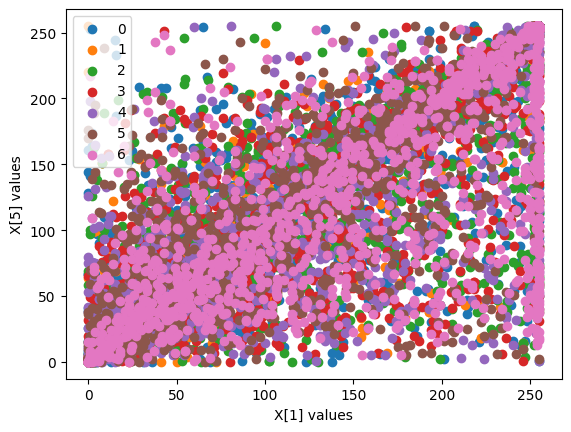

In [76]:
import matplotlib.pyplot as plt
i = 1
j = 5

fig, ax = plt.subplots()
cls = numpy.unique(Y)
ax.set_xlabel(f"X[{i}] values")
ax.set_ylabel(f"X[{j}] values")

for y in cls:
    indx = numpy.where(Y==y)
    Y_plt = Y[indx]
    X_plt = X[indx] 
    ax.scatter(X_plt[:,1], X_plt[:,5], label=f'{y}')
ax.legend()

# LDA

In [64]:
transform = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
X = transform.fit_transform(X, Y)


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# Plotting data after LDA

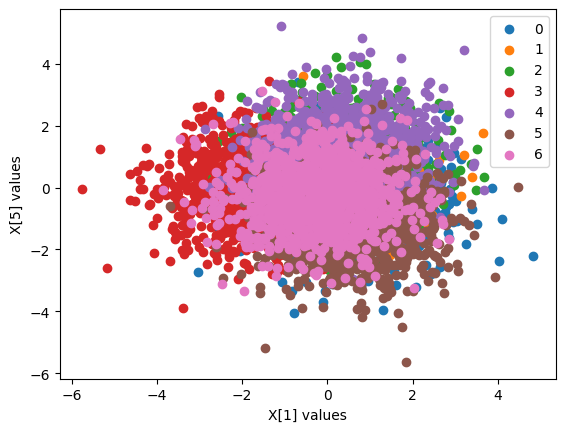

In [65]:
fig, ax = plt.subplots()
cls = numpy.unique(Y)
ax.set_xlabel(f"X[{i}] values")
ax.set_ylabel(f"X[{j}] values")

for y in cls:
    indx = numpy.where(Y==y)
    Y_plt = Y[indx]
    X_plt = X[indx]
    mean_X = numpy.mean(X_plt, axis = 1)
    Var_X  = numpy.var(X_plt, axis=1)
    ax.scatter(X_plt[:,1], X_plt[:,5] , label=f'{y}')
ax.legend()

# SVM

In [66]:
clf_svm = SVC()
clf_svm.fit(X_train,Y_train)

SVC()

In [67]:
from sklearn.metrics import accuracy_score

Y_pred = clf_svm.predict(X_test)
p = accuracy_score(Y_test, Y_pred)

print(p)

0.6536312849162011


In [68]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, Y_pred)

array([[ 91,   1,  10,  12,   4,  13,   9],
       [  2,  32,   5,   2,   1,   3,   2],
       [ 12,   3,  73,  11,   8,  14,   5],
       [  9,   1,   8,  96,  10,  13,   2],
       [ 15,   1,  15,  10,  91,  14,   8],
       [ 13,   3,   7,   7,  10,  77,   1],
       [  6,   2,   9,  10,   8,  11, 125]], dtype=int64)

# XGB

In [69]:
clf_xgb = xgb.XGBClassifier(tree_method="approx", max_depth=30)
clf_xgb.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [70]:
from sklearn.metrics import accuracy_score

Y_pred = clf_xgb.predict(X_test)
p = accuracy_score(Y_test, Y_pred)

print(p)

0.641340782122905


In [71]:
from sklearn.metrics import confusion_matrix

confusion_matrix(Y_test, Y_pred)

array([[ 85,   3,  16,  11,   7,  12,   6],
       [  2,  33,   5,   0,   2,   4,   1],
       [ 14,   2,  68,   8,  10,  18,   6],
       [  8,   2,   8,  98,  10,  11,   2],
       [ 20,   0,  15,   8,  88,  16,   7],
       [  9,   4,   3,  12,   9,  78,   3],
       [  5,   1,  11,  10,   7,  13, 124]], dtype=int64)

# GNB

In [72]:
from sklearn.naive_bayes import GaussianNB

clf_NB = GaussianNB()
clf_NB.fit(X_train,Y_train)

GaussianNB()

In [73]:
from sklearn.metrics import accuracy_score

Y_pred = clf_xgb.predict(X_test)
p = accuracy_score(Y_test, Y_pred)

print(p)
confusion_matrix(Y_test, Y_pred)

0.641340782122905


array([[ 85,   3,  16,  11,   7,  12,   6],
       [  2,  33,   5,   0,   2,   4,   1],
       [ 14,   2,  68,   8,  10,  18,   6],
       [  8,   2,   8,  98,  10,  11,   2],
       [ 20,   0,  15,   8,  88,  16,   7],
       [  9,   4,   3,  12,   9,  78,   3],
       [  5,   1,  11,  10,   7,  13, 124]], dtype=int64)